# XGB Classifier with Wrapper-Based FS

Steven Sison | March 9, 2024

## Description

This document will be used to train a model using the reduced feature set obtain by using the wrapper-based method, forward feature selection. The model will be evaluated in terms of the usual metrics (accuracy, precision, F1-score, recall) as well as the training time. The model will also be stored for future evaluation purposes.

## Training the Model

### Preliminaries

#### 1. Loading the Dataset

In [15]:
import pandas as pd                     # For data transformation
import numpy as numpy                   # For scientific calculations
import seaborn as sns                   # For data visualizations
import matplotlib.pyplot as plt         # For plotting
import plotly.graph_objects as go       # For plotting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import time
from datetime import datetime
import joblib
import os

dataset = pd.read_csv("../../../02_feature-engineering/final-datasets/final_unbalanced_withLexical.csv")      # Loading the dataset

dataset.head()



,url_type,url_length,url_ip_in_domain,url_domain_entropy,url_is_digits_in_domain,url_query_length,url_number_of_parameters,url_number_of_digits,url_string_entropy,url_is_https,...,has_swf_in_string,has_cgi_in_string,has_php_in_string,has_abuse_in_string,has_admin_in_string,has_bin_in_string,has_personal_in_string,has_update_in_string,has_verification_in_string,url_scheme
0,2,16,0,3.169925,0,0,0,0,3.375000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,35,0,2.807355,1,0,0,1,4.079143,0,...,0,0,0,0,0,0,0,0,0,0
2,0,31,0,2.921928,0,0,0,1,3.708093,0,...,0,0,0,0,0,0,0,0,0,0
3,1,88,0,2.896292,0,49,4,7,4.660343,0,...,0,0,1,0,0,0,0,0,0,27
4,1,235,0,3.405822,0,194,3,22,4.980518,0,...,0,0,1,0,0,0,0,0,0,27


In [16]:
dataset.head()

,url_type,url_length,url_ip_in_domain,url_domain_entropy,url_is_digits_in_domain,url_query_length,url_number_of_parameters,url_number_of_digits,url_string_entropy,url_is_https,...,has_swf_in_string,has_cgi_in_string,has_php_in_string,has_abuse_in_string,has_admin_in_string,has_bin_in_string,has_personal_in_string,has_update_in_string,has_verification_in_string,url_scheme
0,2,16,0,3.169925,0,0,0,0,3.375000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,35,0,2.807355,1,0,0,1,4.079143,0,...,0,0,0,0,0,0,0,0,0,0
2,0,31,0,2.921928,0,0,0,1,3.708093,0,...,0,0,0,0,0,0,0,0,0,0
3,1,88,0,2.896292,0,49,4,7,4.660343,0,...,0,0,1,0,0,0,0,0,0,27
4,1,235,0,3.405822,0,194,3,22,4.980518,0,...,0,0,1,0,0,0,0,0,0,27


In [17]:
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['url_type']), dataset['url_type'], test_size = 0.2, random_state=42)

#### 2. Preprocessing (Balancing)

In [18]:
dataset['url_type'].value_counts()

url_type
0    428080
2    134094
1     95308
3     26700
Name: count, dtype: int64

#### 3. Removing Unnecessary Features

In [19]:
important_features_wrapper_12 = ['url_domain_entropy', 'url_number_of_digits', 'url_path_length', 'url_host_length', 'get_tld', 'url_num_subdomain', 'url_number_of_letters', 'url_num_periods', 'url_num_forward_slash', 'has_login_in_string', 'has_php_in_string', 'url_scheme']
important_features_wrapper_33 = ['url_length',
 'url_domain_entropy',
 'url_is_digits_in_domain',
 'url_number_of_parameters',
 'url_number_of_digits',
 'url_string_entropy',
 'url_path_length',
 'url_host_length',
 'get_tld',
 'url_domain_len',
 'url_num_subdomain',
 'url_number_of_fragments',
 'url_is_encoded',
 'url_number_of_letters',
 'url_num_periods',
 'url_num_of_hyphens',
 'url_num_underscore',
 'url_num_forward_slash',
 'url_num_semicolon',
 'url_num_mod_sign',
 'has_login_in_string',
 'has_signin_in_string',
 'has_logon_in_string',
 'has_loginasp_in_string',
 'has_exe_in_string',
 'has_viewerphp_in_string',
 'has_getImageasp_in_string',
 'has_paypal_in_string',
 'has_dbsysphp_in_string',
 'has_shopping_in_string',
 'has_php_in_string',
 'has_bin_in_string',
 'has_personal_in_string',
 'url_scheme'
 ]

X_test_12 = x_test[important_features_wrapper_12]
X_train_12 = x_train[important_features_wrapper_12]

X_test_33 = x_test[important_features_wrapper_33]
X_train_33 = x_train[important_features_wrapper_33]

X_test_33.head()

,url_length,url_domain_entropy,url_is_digits_in_domain,url_number_of_parameters,url_number_of_digits,url_string_entropy,url_path_length,url_host_length,get_tld,url_domain_len,...,has_exe_in_string,has_viewerphp_in_string,has_getImageasp_in_string,has_paypal_in_string,has_dbsysphp_in_string,has_shopping_in_string,has_php_in_string,has_bin_in_string,has_personal_in_string,url_scheme
413009,54,3.787144,0,0,0,4.353985,21,26,332,19,...,0,0,0,0,0,0,0,0,0,27
263408,19,3.506891,0,0,0,3.616349,19,0,0,15,...,0,0,0,0,0,0,0,0,0,0
596213,28,2.521641,0,0,1,3.869331,28,0,0,7,...,0,0,0,0,0,0,0,0,0,0
349052,123,3.621928,0,2,26,4.979202,28,27,332,20,...,0,0,0,0,0,0,0,0,0,27
106040,36,3.169925,0,0,0,4.009524,13,16,332,9,...,0,0,0,0,0,0,0,0,0,27


#### Model Training

In [20]:
from sklearn.model_selection import KFold

# Initialize CV
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Set Hyperparameters
params_gbm = {'eta': 0.2660984929457465,
              'objective': 'multi:softmax',
              'max_depth': 10,
              'subsample': 0.8197225669267219,
              'colsample_bytree': 0.9893540865745749,
              'gamma': 0.05040746966680979,
              'min_child_weight': 5.3821851133593634,
              'lambda': 0.9274786210352317,
              'alpha': 3.6297170639237653,
              'num_boost_round': 50000
              }

# Initialize the model
xgb_classifier_12 = XGBClassifier(params_gbm)
xgb_classifier_33 = XGBClassifier(params_gbm)

# Train the Model
eval_set = [(x_test, y_test)]

xgb_classifier_12.fit(X_train_12, y_train, eval_metric="error", verbose=True)
y_pred_12 = xgb_classifier_12.predict(X_test_12)

xgb_classifier_33.fit(X_train_33, y_train, eval_metric="error",verbose=True)
y_pred_33 = xgb_classifier_33.predict(X_test_33)

c:\Users\sison\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\sison\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


c:\Users\sison\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


#### Evaluation

In [21]:
# Classification Report
print(classification_report(y_test, y_pred_12))
print(classification_report(y_test, y_pred_33))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85560
           1       0.95      0.99      0.97     18804
           2       0.90      0.83      0.86     27061
           3       0.97      0.88      0.93      5412

    accuracy                           0.95    136837
   macro avg       0.95      0.92      0.93    136837
weighted avg       0.94      0.95      0.94    136837

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85560
           1       0.96      0.99      0.98     18804
           2       0.91      0.84      0.87     27061
           3       0.99      0.91      0.95      5412

    accuracy                           0.95    136837
   macro avg       0.95      0.93      0.94    136837
weighted avg       0.95      0.95      0.95    136837



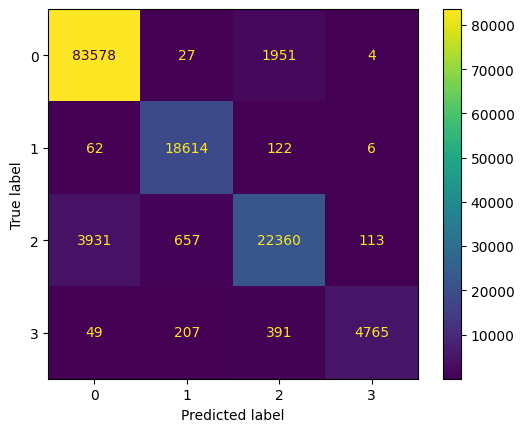

In [22]:
# Confusion Matrix for 12 Features
cm_up = confusion_matrix(y_test, y_pred_12, labels=xgb_classifier_12.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_up, display_labels = xgb_classifier_12.classes_)
disp.plot()
plt.show()

In [23]:
'''# Cross Validation Score
scores = cross_val_score(XGBClassifier(**params_gbm),
                        X_train, y_train, scoring='accuracy', cv=cv).mean()

print(scores)'''

"# Cross Validation Score\nscores = cross_val_score(XGBClassifier(**params_gbm),\n                        X_train, y_train, scoring='accuracy', cv=cv).mean()\n\nprint(scores)"

In [24]:
# Dumping the model
joblib.dump(xgb_classifier_12, 'xgb_ffs_12.sav')
joblib.dump(xgb_classifier_33, 'xgb_ffs_33.sav')

['xgb_ffs_33.sav']

In [34]:
import lexical_generator_12
import lexical_generator_33
import time

def xgb_predict_maliciousness_12(url):

    numerical_values = lexical_generator_12.lexical_generator(url)
    # print(numerical_values)

    match xgb_classifier_12.predict(numerical_values):
        case 0:
            return "Benign"
        case 1:
            return "Malware"
        case 2:
            return "Phishing"
        case 3:
            return "Defacement"
        
def xgb_predict_maliciousness_33(url):

    numerical_values = lexical_generator_33.lexical_generator(url)
    # print(numerical_values)

    numerical_values.head()

    match xgb_classifier_33.predict(numerical_values):
        case 0:
            return "Benign"
        case 1:
            return "Malware"
        case 2:
            return "Phishing"
        case 3:
            return "Defacement"

url = "www.facebook.com/stevenography/"
print("Current URL: "+url)

start = time.perf_counter()
prediction = xgb_predict_maliciousness_12(url)
end = time.perf_counter()
print("------- 12 Features -------------")
print(prediction)
print(end-start)

start = time.perf_counter()
prediction = xgb_predict_maliciousness_33(url)
end = time.perf_counter()
print("------- 33 Features -------------")
print(prediction)
print(end-start)

Current URL: www.facebook.com/stevenography/
------- 12 Features -------------
Benign
0.009159500012174249
------- 33 Features -------------
Phishing
0.017678199976217
